## importing packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

### loading data

In [2]:
df = pd.read_csv('../data/clean_data.csv')

### columns inspection

In [3]:
df.columns

Index(['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'Dur. (ms)', 'IMSI',
       'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)',
       'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
       'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)',
       '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)',
       'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)',
       '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)',
       'Activity Duration DL (ms)', 'Activity Duration UL (ms)', 'Dur. (ms).1',
       'Handset Manufacturer', 'Handset Type', 'Nb of sec with Vol DL < 6250B',
       'Nb of sec with Vol UL < 1250B', 'Social Media DL (Bytes)',
       'Social Media UL (Bytes)', 'Google DL (Bytes)', 'Google UL (Bytes)',
       'Email DL (Bytes)', 'Email UL (Bytes)', 'Youtube DL (Bytes)',
       'Youtube UL (Bytes)', 'Netflix DL (Bytes)', 'Netflix UL (Bytes)',
       'Gaming DL (Bytes)', 'Gaming UL (Bytes)', 'Other DL (Bytes)',


### Data Aggregation

In [4]:
from sklearn.impute import SimpleImputer

# Replace missing values for continuous and categorical columns
imputer_mean = SimpleImputer(strategy='mean')
imputer_mode = SimpleImputer(strategy='most_frequent')

df['Avg RTT DL (ms)'] = imputer_mean.fit_transform(df[['Avg RTT DL (ms)']])
df['Avg RTT UL (ms)'] = imputer_mean.fit_transform(df[['Avg RTT UL (ms)']])
df['Avg Bearer TP DL (kbps)'] = imputer_mean.fit_transform(df[['Avg Bearer TP DL (kbps)']])
df['Avg Bearer TP UL (kbps)'] = imputer_mean.fit_transform(df[['Avg Bearer TP UL (kbps)']])
df['Nb of sec with Vol DL < 6250B'] = imputer_mean.fit_transform(df[['Nb of sec with Vol DL < 6250B']])
df['Nb of sec with Vol UL < 1250B'] = imputer_mean.fit_transform(df[['Nb of sec with Vol UL < 1250B']])
# Impute missing values for 'Handset Type' and reshape to 1D array
df['Handset Type'] = imputer_mode.fit_transform(df[['Handset Type']]).ravel()

# Calculate additional metrics
df['Average RTT'] = (df['Avg RTT DL (ms)'] + df['Avg RTT UL (ms)']) / 2
df['Average Throughput'] = (df['Avg Bearer TP DL (kbps)'] + df['Avg Bearer TP UL (kbps)']) / 2
df['TCP Retransmission'] = (df['Nb of sec with Vol DL < 6250B'] + df['Nb of sec with Vol UL < 1250B']) / 2

# Aggregate data per customer
df_agg = df.groupby('MSISDN/Number').agg({
    'TCP Retransmission': 'mean',
    'Average RTT': 'mean',
    'Average Throughput': 'mean',
    'Handset Type': 'first'  # Or mode
}).reset_index()

# Show the first few rows
df_agg.head()

,MSISDN/Number,TCP Retransmission,Average RTT,Average Throughput,Handset Type
0,3.360100e+10,76.5,23.00,38.0,Huawei P20 Lite Huawei Nova 3E
1,3.360100e+10,234.5,15.50,49.5,Apple iPhone 7 (A1778)
2,3.360100e+10,91.5,16.50,48.5,undefined
3,3.360101e+10,105.5,42.00,124.0,Apple iPhone 5S (A1457)
4,3.360101e+10,2743.5,29.75,14211.0,Apple iPhone Se (A1723)


In [5]:
df_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106856 entries, 0 to 106855
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   MSISDN/Number       106856 non-null  float64
 1   TCP Retransmission  106856 non-null  float64
 2   Average RTT         106856 non-null  float64
 3   Average Throughput  106856 non-null  float64
 4   Handset Type        106856 non-null  object 
dtypes: float64(4), object(1)
memory usage: 4.1+ MB


In [6]:
# Top 10 TCP, RTT, Throughput
for col in ['TCP Retransmission', 'Average RTT', 'Average Throughput']:
    top_10 = df_agg[col].nlargest(10)
    bottom_10 = df_agg[col].nsmallest(10)
    most_frequent = df_agg[col].mode()[0]
    
    print(f"Top 10 {col} values:\n", top_10)


Top 10 TCP Retransmission values:
 100081    604091.5
100614    482111.5
71714     418695.5
66936     345068.0
100590    313885.0
95205     302681.0
100586    286173.0
100613    276978.0
95426     275998.5
87159     261969.5
Name: TCP Retransmission, dtype: float64
Top 10 Average RTT values:
 47983     48462.00
80249     27424.00
41944     16167.50
93844     13639.00
1713      13150.00
74240     12857.50
104325    12694.00
105752    12369.00
85683     11505.25
15409     10490.00
Name: Average RTT, dtype: float64
Top 10 Average Throughput values:
 37838     141965.50
49595     132862.00
60763     132588.25
52830     127475.00
14564     119491.00
10359     117682.50
104697    115491.00
27722     114151.50
92374     113667.00
98280     113252.50
Name: Average Throughput, dtype: float64


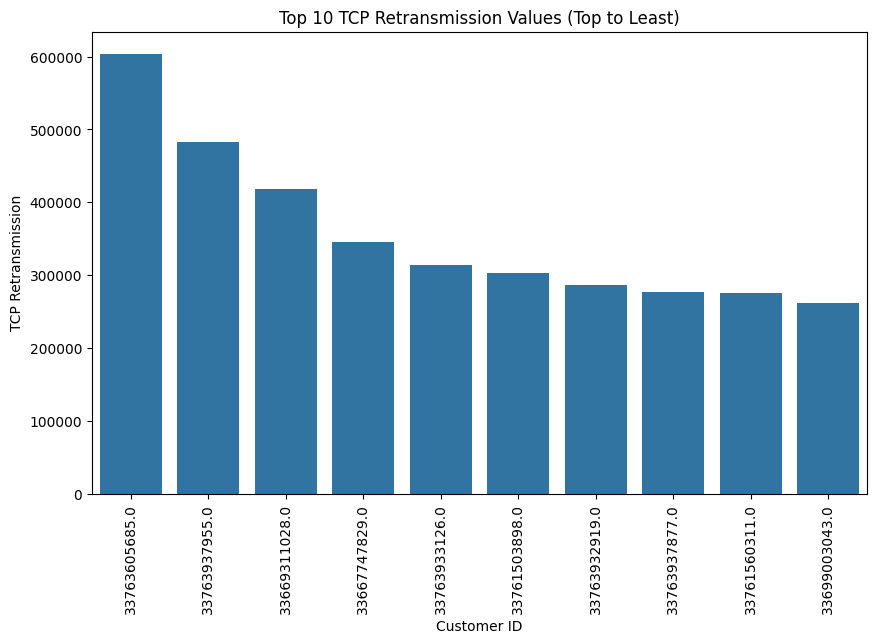

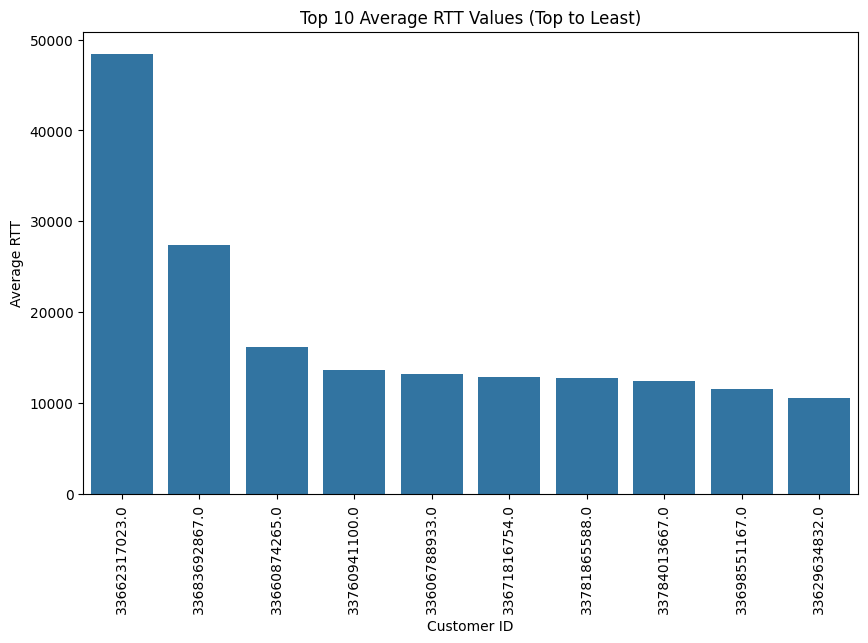

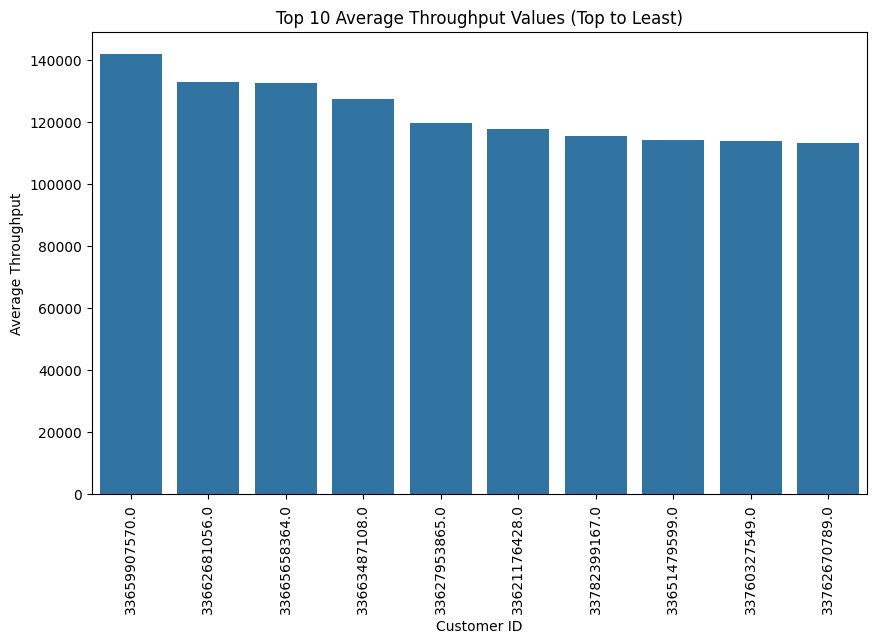

In [7]:
# Function to plot top 10 values in descending order (from more to least)
def plot_top(data, column, title):
    # Get the top 10 values (sorted in descending order)
    top_10 = data.nlargest(10, column)
    
    # Plotting as vertical bars (more to least)
    plt.figure(figsize=(10,6))
    sns.barplot(x=top_10['MSISDN/Number'], y=top_10[column], order=top_10['MSISDN/Number'])
    plt.xticks(rotation=90)
    plt.title(title)
    plt.ylabel(column)
    plt.xlabel('Customer ID')
    plt.show()

# Plot top 10 for each metric (from top to least)
for col in ['TCP Retransmission', 'Average RTT', 'Average Throughput']:
    plot_top(df_agg, col, f"Top 10 {col} Values (Top to Least)")

In [8]:
# Bottom 10 TCP, RTT, Throughput
for col in ['TCP Retransmission', 'Average RTT', 'Average Throughput']:
    top_10 = df_agg[col].nlargest(10)
    bottom_10 = df_agg[col].nsmallest(10)
    most_frequent = df_agg[col].mode()[0]
    
    print(f"Bottom 10 {col} values:\n", bottom_10)



Bottom 10 TCP Retransmission values:
 230     1.0
931     1.0
1038    1.0
2298    1.0
2671    1.0
3738    1.0
4563    1.0
4567    1.0
5559    1.0
5734    1.0
Name: TCP Retransmission, dtype: float64
Bottom 10 Average RTT values:
 28878    0.0
44748    0.0
39066    1.0
83396    2.0
36039    2.5
69662    3.0
21980    4.0
3882     4.5
74434    4.5
17863    5.0
Name: Average RTT, dtype: float64
Bottom 10 Average Throughput values:
 857     0.0
1204    0.0
2473    0.0
2605    0.0
2671    0.0
3238    0.0
3738    0.0
4276    0.0
7196    0.0
7518    0.0
Name: Average Throughput, dtype: float64


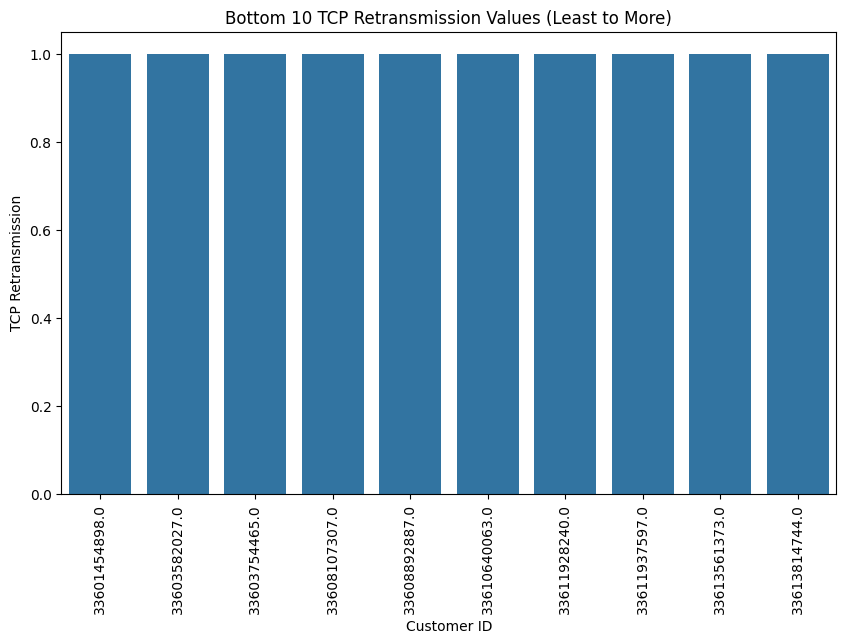

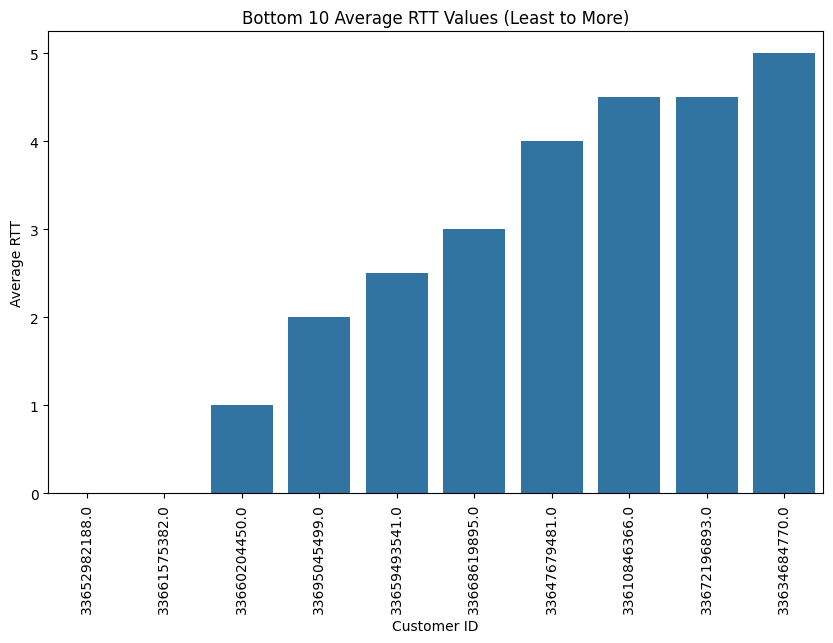

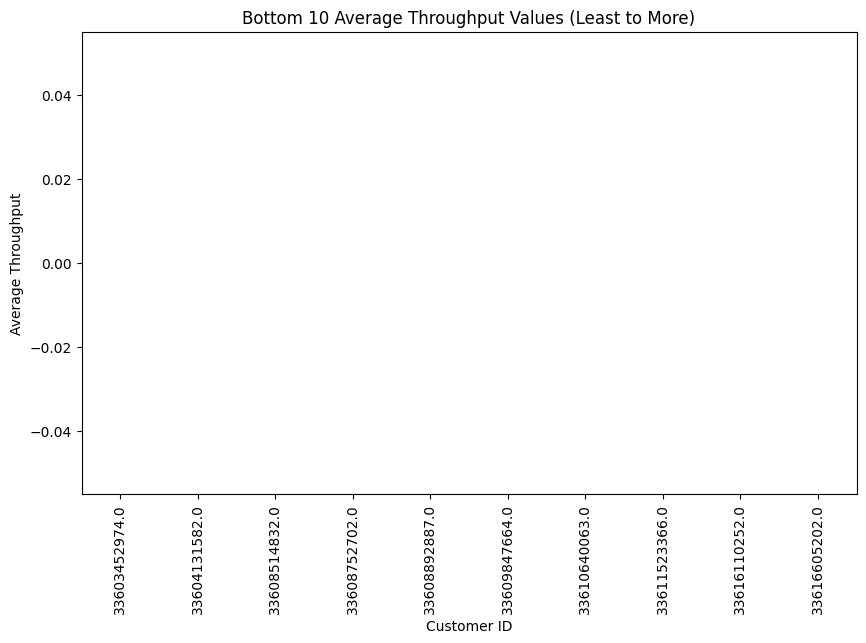

In [9]:
# Function to plot bottom 10 values in ascending order (from least to more)
def plot_bottom(data, column, title):
    # Get the bottom 10 values (sorted in ascending order)
    bottom_10 = data.nsmallest(10, column)
    
    # Sort the DataFrame by column values for proper bar ordering
    bottom_10_sorted = bottom_10.sort_values(by=column, ascending=True)
    
    # Plotting as vertical bars (least to more)
    plt.figure(figsize=(10,6))
    sns.barplot(x='MSISDN/Number', y=column, data=bottom_10_sorted, order=bottom_10_sorted['MSISDN/Number'])
    plt.xticks(rotation=90)
    plt.title(title)
    plt.ylabel(column)
    plt.xlabel('Customer ID')
    plt.show()

# Plot bottom 10 for each metric (from least to more)
for col in ['TCP Retransmission', 'Average RTT', 'Average Throughput']:
    plot_bottom(df_agg, col, f"Bottom 10 {col} Values (Least to More)")


In [10]:
# Most Frequent TCP, RTT, Throughput
for col in ['TCP Retransmission', 'Average RTT', 'Average Throughput']:
    top_10 = df_agg[col].nlargest(10)
    bottom_10 = df_agg[col].nsmallest(10)
    most_frequent = df_agg[col].mode()[0]
    
    print(f"Most frequent {col} value:\n", most_frequent)


Most frequent TCP Retransmission value:
 3.0
Most frequent Average RTT value:
 16.5
Most frequent Average Throughput value:
 7.5


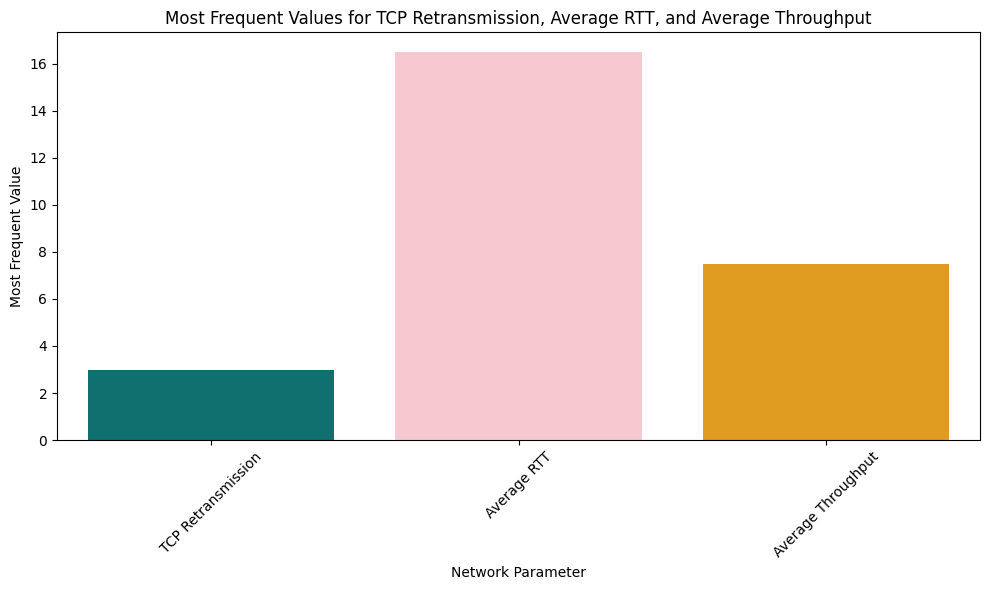

In [11]:
# List of columns to visualize
columns = ['TCP Retransmission', 'Average RTT', 'Average Throughput']

# Initialize a dictionary to store most frequent values
most_frequent_values = {}

# Loop through the columns and get the most frequent value (mode)
for col in columns:
    most_frequent_values[col] = df_agg[col].mode()[0]

# Convert to a DataFrame for easy plotting
most_frequent_df = pd.DataFrame(most_frequent_values, index=['Most Frequent']).T

# Plotting the most frequent values as a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=most_frequent_df.index, y=most_frequent_df['Most Frequent'], hue=most_frequent_df.index, 
            palette=['teal', 'pink', 'orange'], dodge=False, legend=False)
plt.title("Most Frequent Values for TCP Retransmission, Average RTT, and Average Throughput")
plt.ylabel("Most Frequent Value")
plt.xlabel("Network Parameter")
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

In [12]:
# Group data by Handset Type and compute the average for each metric
throughput_per_handset = df_agg.groupby('Handset Type')['Average Throughput'].mean().reset_index()
tcp_retransmission_per_handset = df_agg.groupby('Handset Type')['TCP Retransmission'].mean().reset_index()

# Sort values and select the top 10 for easier interpretation in horizontal bar plot
throughput_per_handset_top10 = throughput_per_handset.sort_values('Average Throughput', ascending=False).head(10)
tcp_retransmission_per_handset_top10 = tcp_retransmission_per_handset.sort_values('TCP Retransmission', ascending=False).head(10)

/tmp/ipykernel_15710/1804376623.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Handset Type',y='Average Throughput', data=throughput_per_handset_top10, palette= 'viridis')


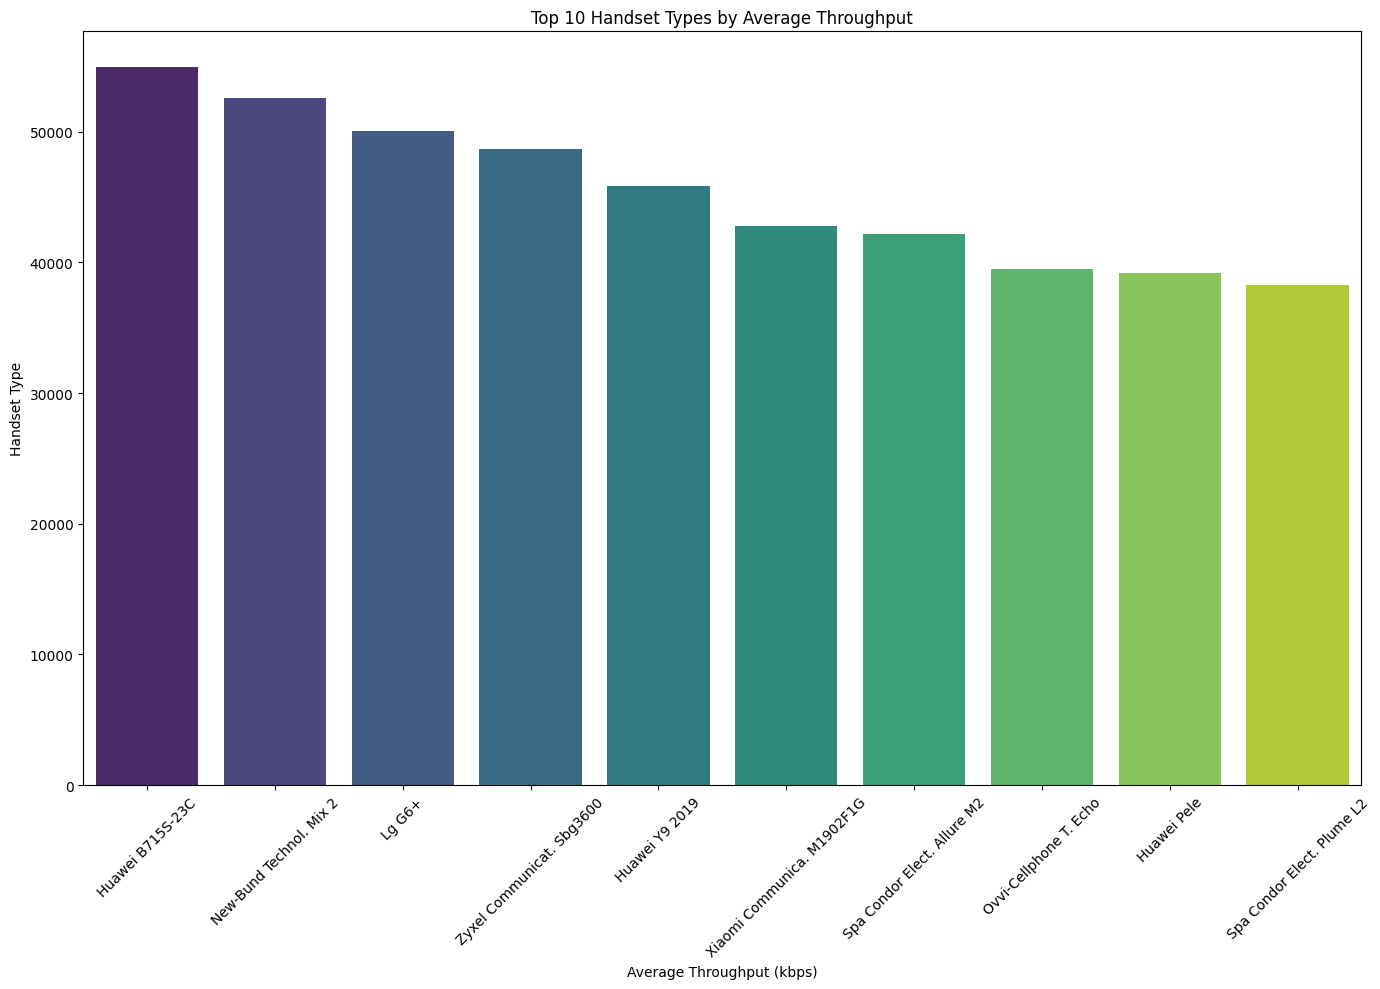

In [13]:
# Horizontal Bar Plot: Average Throughput per Handset Type (Top 10)
plt.figure(figsize=(14, 10))
ax = sns.barplot(x='Handset Type',y='Average Throughput', data=throughput_per_handset_top10, palette= 'viridis')
plt.title('Top 10 Handset Types by Average Throughput')
plt.xlabel('Average Throughput (kbps)')
plt.ylabel('Handset Type')
plt.xticks(rotation=45)  # Tilt x-axis labels
plt.tight_layout()
plt.show()

/tmp/ipykernel_15710/3997849502.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Handset Type', y='TCP Retransmission', data=tcp_retransmission_per_handset_top10, palette='coolwarm')


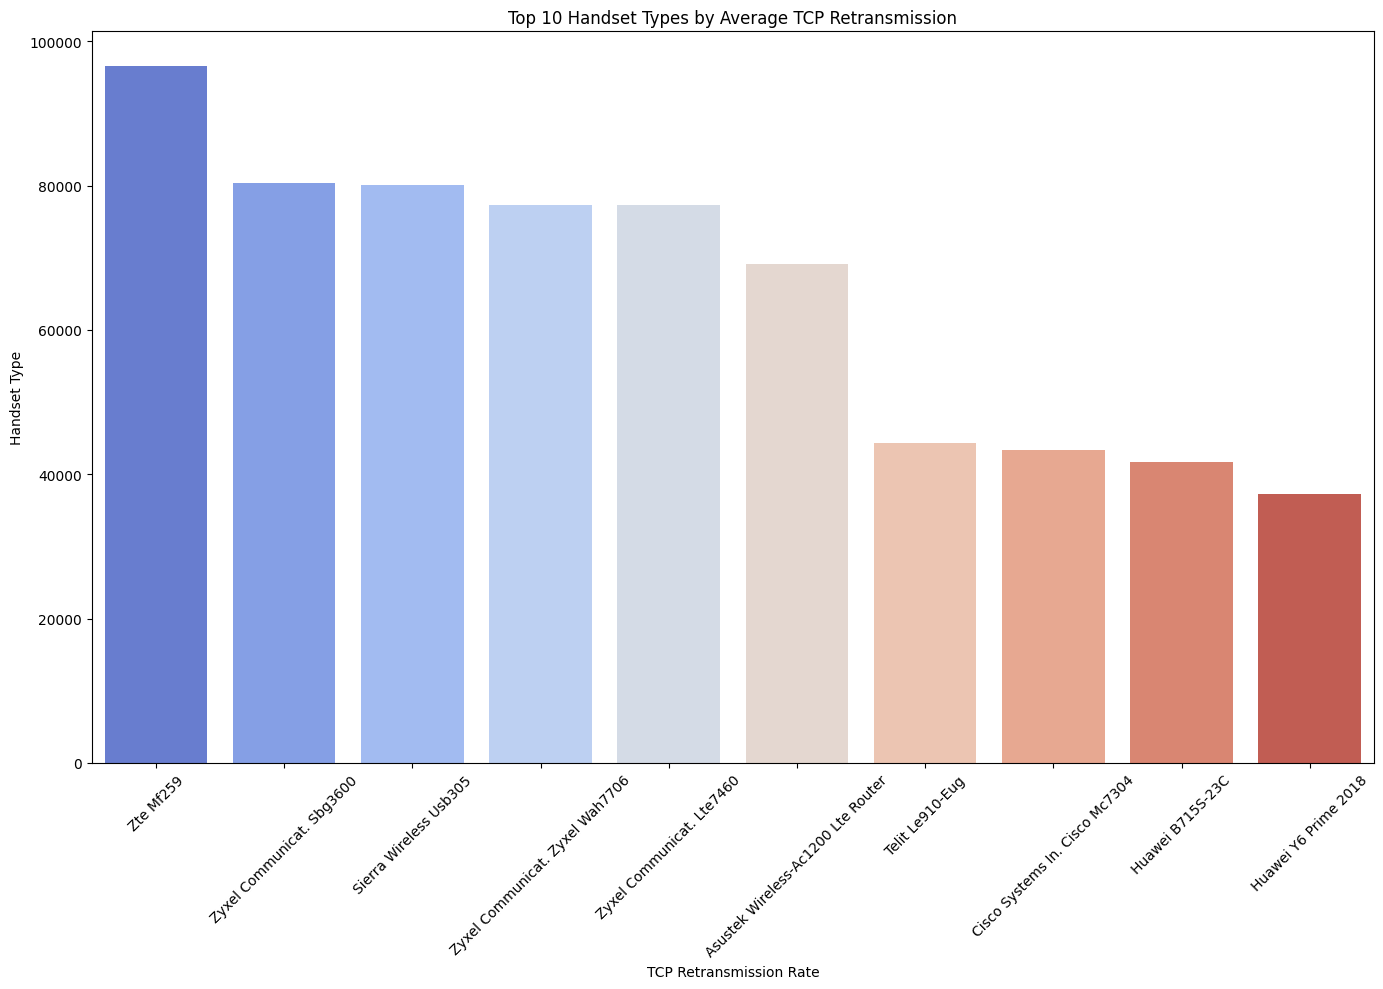

In [14]:
# Horizontal Bar Plot: Average TCP Retransmission per Handset Type (Top 10)
plt.figure(figsize=(14, 10))
ax = sns.barplot(x='Handset Type', y='TCP Retransmission', data=tcp_retransmission_per_handset_top10, palette='coolwarm')
plt.title('Top 10 Handset Types by Average TCP Retransmission')
plt.xlabel('TCP Retransmission Rate')
plt.ylabel('Handset Type')
plt.xticks(rotation=45)  # Tilt x-axis labels
plt.tight_layout()
plt.show()

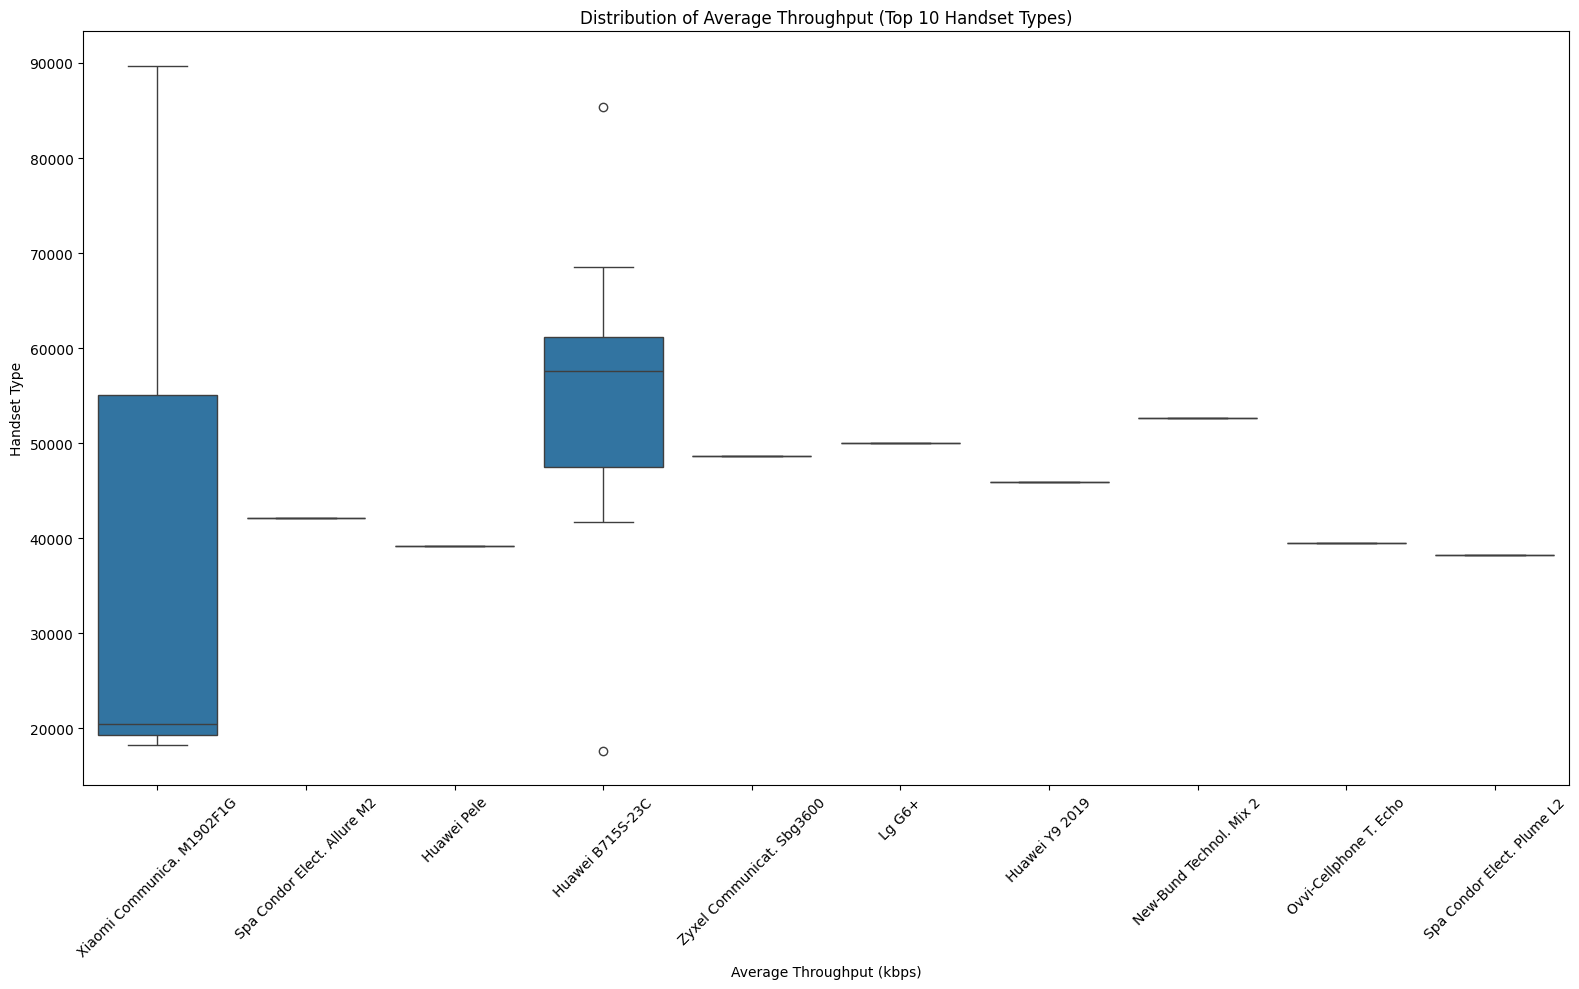

In [15]:
# Boxplot: Distribution of Throughput for Top 10 Handset Types
plt.figure(figsize=(16, 10))
ax = sns.boxplot(x='Handset Type',y='Average Throughput', data=df_agg[df_agg['Handset Type'].isin(throughput_per_handset_top10['Handset Type'])])
plt.title('Distribution of Average Throughput (Top 10 Handset Types)')
plt.xlabel('Average Throughput (kbps)')
plt.ylabel('Handset Type')
plt.xticks(rotation=45)  # Tilt x-axis labels
plt.tight_layout()
plt.show()

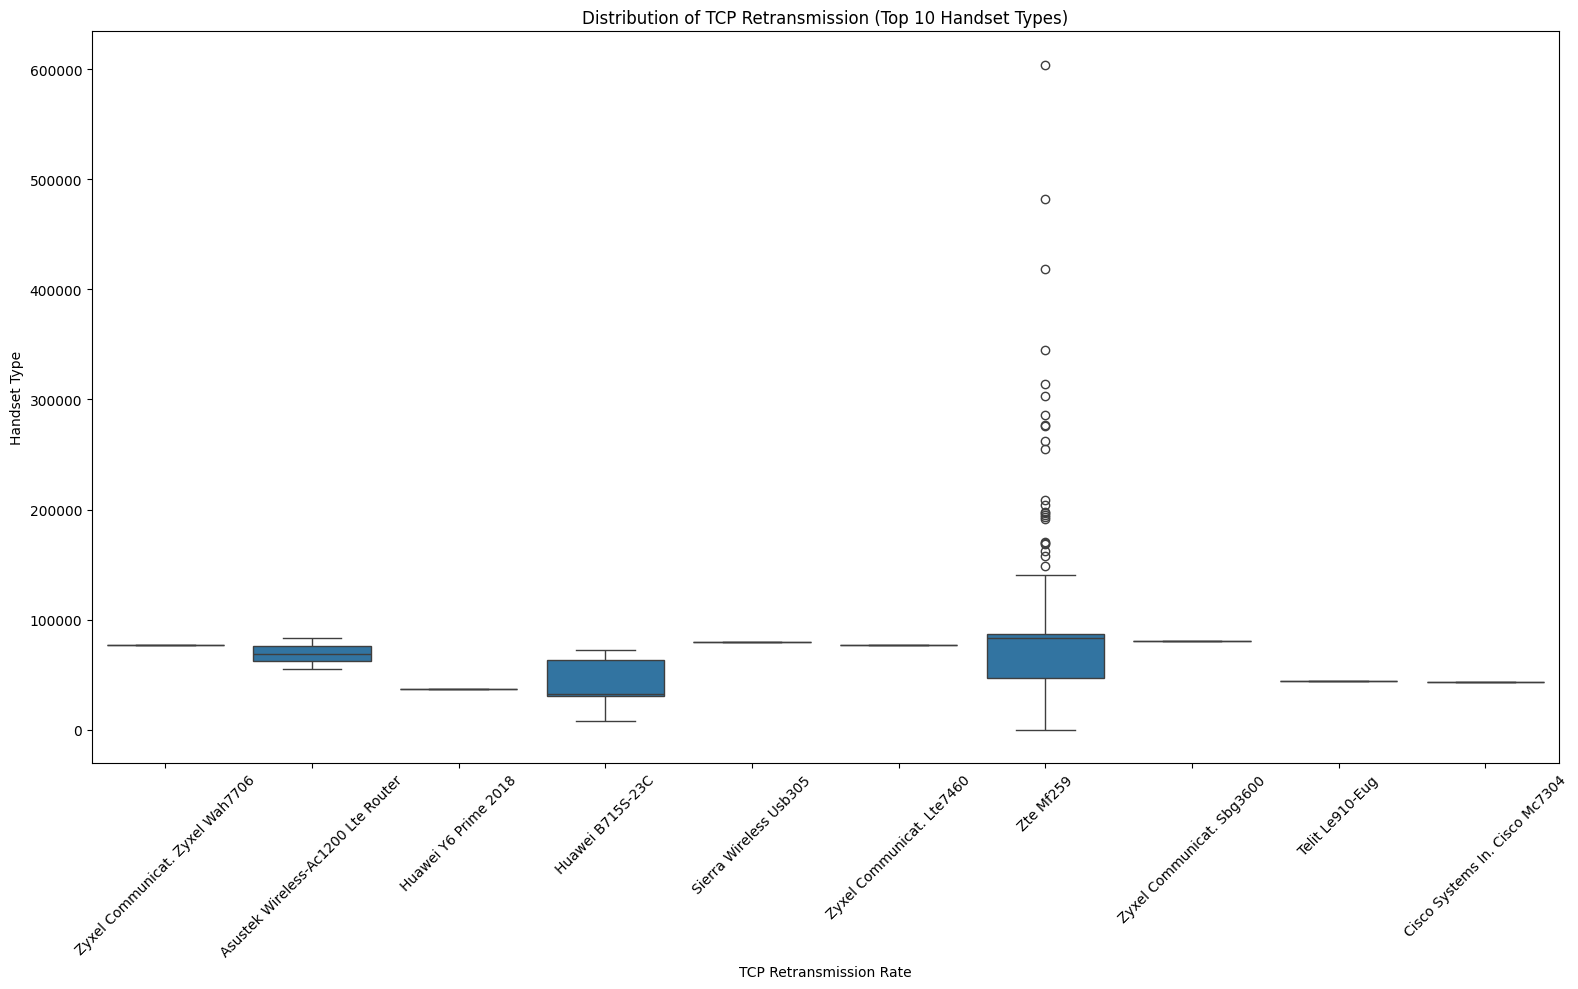

In [16]:
# Boxplot: Distribution of TCP Retransmission for Top 10 Handset Types
plt.figure(figsize=(16, 10))
ax = sns.boxplot(x='Handset Type', y='TCP Retransmission', data=df_agg[df_agg['Handset Type'].isin(tcp_retransmission_per_handset_top10['Handset Type'])])
plt.title('Distribution of TCP Retransmission (Top 10 Handset Types)')
plt.xlabel('TCP Retransmission Rate')
plt.ylabel('Handset Type')
plt.xticks(rotation=45)  # Tilt x-axis labels
plt.tight_layout()
plt.show()

### K-Means Clustering

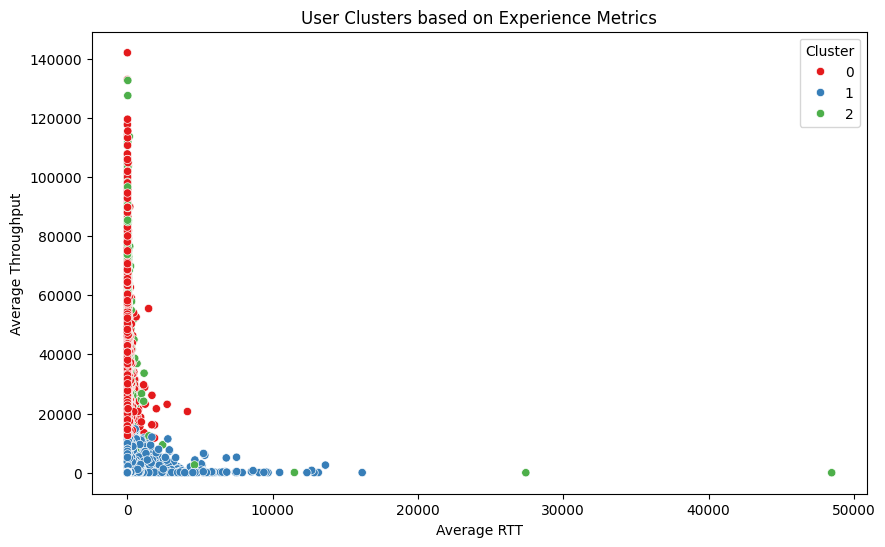

   Cluster  TCP Retransmission  Average RTT  Average Throughput
0        0         7452.056307    49.624004        25016.445230
1        1          736.929882    57.612672         1824.197588
2        2        36302.418765    99.574198        26197.020272


In [17]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select features for clustering
X = df_agg[['TCP Retransmission', 'Average RTT', 'Average Throughput']]

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply k-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df_agg['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualize clusters
plt.figure(figsize=(10,6))
sns.scatterplot(x='Average RTT', y='Average Throughput', hue='Cluster', data=df_agg, palette='Set1')
plt.title("User Clusters based on Experience Metrics")
plt.show()

# Summary of clusters
cluster_summary = df_agg.groupby('Cluster').agg({
    'TCP Retransmission': 'mean',
    'Average RTT': 'mean',
    'Average Throughput': 'mean'
}).reset_index()

print(cluster_summary)